In [2]:
import pandas as pd
import numpy as np
import os
import pickle

from tqdm import tqdm, tqdm_notebook

In [3]:
os.getcwd()

'/root/HSE_final/notebooks'

In [4]:
prefix = '../features/audio/'
ID_dict = {}
for ID in os.listdir(prefix):
    ID_dict[ID] = {}
    ID_dict[ID]['audio_len'] = len(os.listdir('../features/audio/%s'%ID))
    path = '../features/video/%s'%ID
    ID_dict[ID]['video_len'] = len(os.listdir(path)) if os.path.exists(path) else 0

In [5]:
audio_len_id = sum([i['audio_len']!=0 for i in ID_dict.values()])
video_len_id = sum([i['video_len']!=0 for i in ID_dict.values()])

print('uniq audio id %d'%audio_len_id)
print('uniq video id %d'%video_len_id)

print('\n====\n')

audio_len = sum([i['audio_len'] for i in ID_dict.values()])
video_len = sum([i['video_len'] for i in ID_dict.values()])
print('uniq audio segments %d'%audio_len)
print('uniq video segments %d'%video_len)

print('\n====\n')


ID_list = [i[0] for i in ID_dict.items() if i[1]['audio_len'] == i[1]['video_len']]
print('len of all ids %d'%len(ID_list))
pickle.dump(ID_list, open('uniq_id_list.pickle', 'wb'))

uniq audio id 479
uniq video id 329

====

uniq audio segments 81601
uniq video segments 50990

====

len of all ids 329


### Find  length of video and correct Id's

In [56]:
df = pd.DataFrame(ID_dict).T
df['LEN'] = df['audio_len']*2/60
df['parsed'] = [i==k for i,k in df[['audio_len', 'video_len']].get_values()]

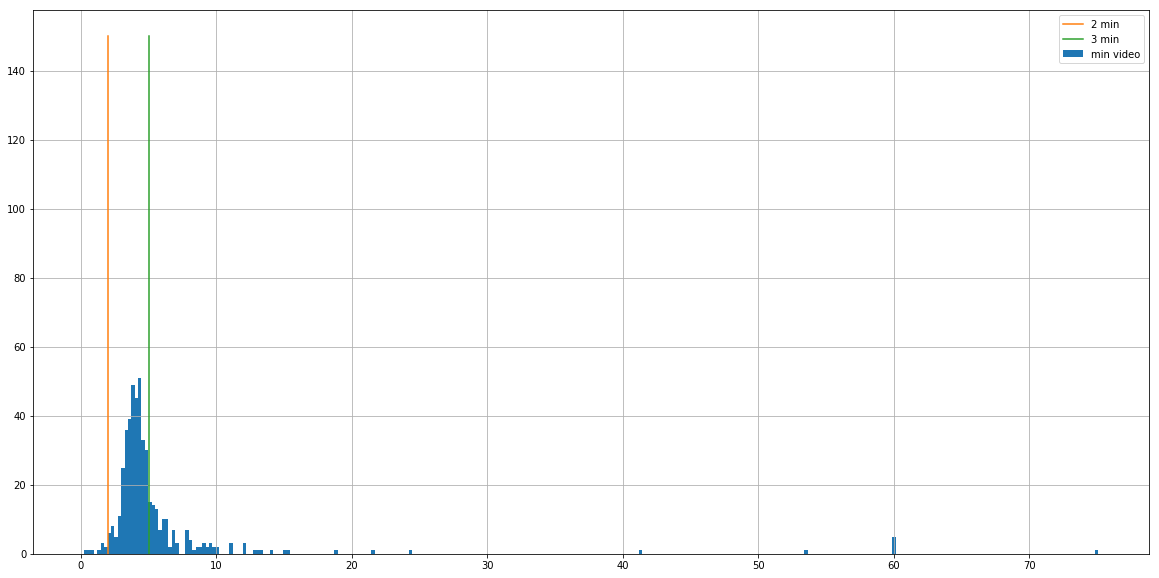

In [44]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize = (20, 10))
df['LEN'].hist(bins = 300, label = 'min video')
# plt.plot([1,1], [0, 150], label = '1 min')
plt.plot([2,2], [0, 150], label = '2 min')
# plt.plot([3,3], [0, 150], label = '3 min')
plt.plot([5,5], [0, 150], label = '3 min')
# plt.plot([10,10], [0, 150], label = '3 min')
plt.legend()
plt.show()

In [64]:
df.head()

,audio_len,video_len,LEN,parsed
-7s5pAQw9-g,108,0,3.600000,False
-JfEJq56IwI,120,120,4.000000,True
-N4jf6rtyuw,89,89,2.966667,True
-O49BRUvWXw,297,0,9.900000,False
-_zf_c9-eX4,102,102,3.400000,True


### Оставим только видео от 2 минут до 5

In [71]:
normal_IDs = list(set(df[df['LEN'] <= 5][df['LEN'] >= 2][df['parsed']==True].index))
print("Normal video's len", len(normal_IDs))

Normal video's len 254


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [76]:
# len(normal_IDs)

In [77]:
# len(set(df[df['LEN'] <= 5][df['LEN'] >= 2][df['parsed'] == True].index))

In [78]:
# video_len = {}
# video_len_from_video_features = {}
# for ID, obj in ID_dict.items():
#     video_len = 

329

In [79]:
# max(ID_dict.items(), key = lambda x : x[1]['audio_len'])

In [10]:
# "%.4d"%719809097

In [81]:
import pickle
def get_raw_video_features(ID, segm):
    fn = '../features/video/%s/%.4d.pickle'%(ID, segm)
    res = pickle.load(open(fn, 'rb'))
    return res

def get_video_features(ID, segm, layer='-1', funct='mean'):
    res = get_raw_video_features(ID, segm)
    return res['features'][layer][funct][0]


test_ID, test_segm = normal_IDs[0], 1 
# res = get_raw_video_features(test_ID, test_segm)
# get_video_features(test_ID, test_segm)

def get_raw_audio_features(ID, segm):
    fn = '../features/audio/%s/%.4d.pickle'%(ID, segm)
    res = pickle.load(open(fn, 'rb'))
    return res

def get_audio_features(ID, segm, layer = '-2'):
    layer = 0 if layer == '-2' else layer
    layer = 1 if layer == '-3' else layer
    
    res = get_raw_audio_features(ID, segm)
    #print(res)
    return res[layer]

def calculate_final_dict(id_list): 
    audio_layer = '-3'
    video_layer = '-1'
    video_funct = 'mean'

    df_results = []
    for ID in tqdm_notebook(normal_IDs):
        num_of_segm = len(os.listdir('../features/audio/%s/'%ID))
        for segm in range(num_of_segm):
            video_feat = get_video_features(ID, segm, layer=video_layer, funct = video_funct)
            audio_feat = get_audio_features(ID, segm, layer=audio_layer)
            unique_ID = ("%s%.4d")%(ID, segm)
            res = {'ID'   : ID,
                   'segm' : segm,
                   'IDu'  : unique_ID
                  }

            for n, val in enumerate(audio_feat):
                res['audio_%d'%n] = val

            for n, val in enumerate(video_feat):
                res['video_%d'%n] = val

            df_results.append(res.copy())

df = calculate_final_dict(normal_IDs)

In [83]:
%%time
path = '../table/'
if not os.path.exists(path):
    os.mkdir(path)
    
pickle.dump(df, open(path+"table.pickle", 'wb'))

In [85]:
%%time
df = pd.DataFrame(df)

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 16.2 µs


In [113]:
%%time
df.to_csv(path+'table.csv', index = False)
# path

(29591, 1515)


61
149


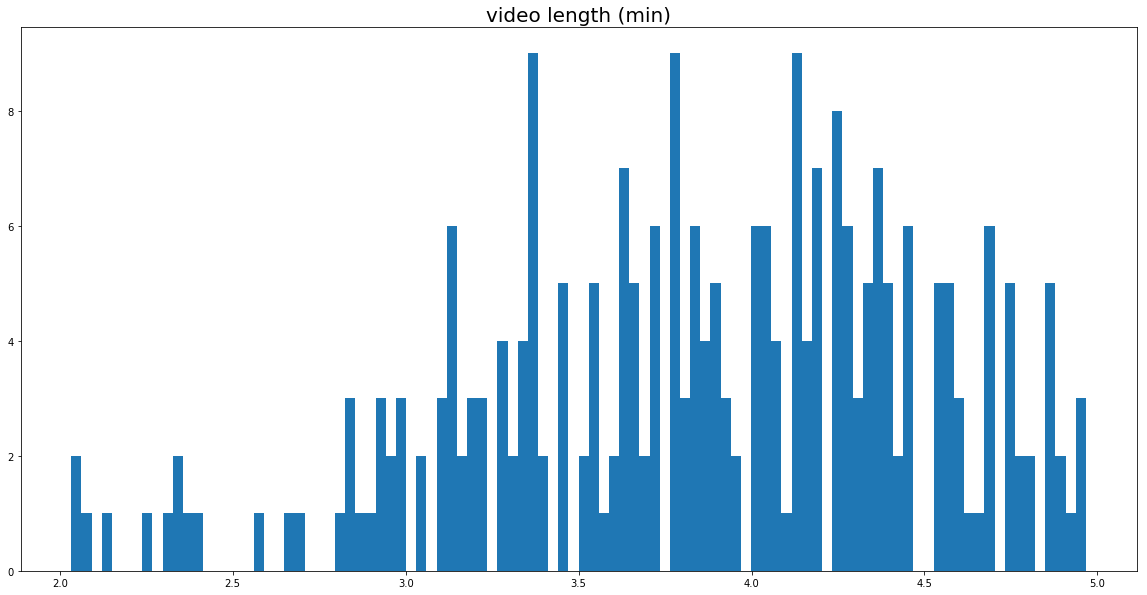

In [116]:
#Calculate video's length
res = {}
for i, obj in tqdm_notebook(df_results.groupby('ID')):
    res[i] = obj['segm'].max()
print(min(res.values()))
print(max(res.values()))

plt.figure(figsize = (20, 10))
plt.title('video length (min)', fontsize = 20)
plt.hist([i*2/60 for i in res.values()], bins = 100)
plt.savefig('../pictures/video_length.png')
plt.show()

# Дальше говно 
(его можно удалить после 26-го числа включительно)

In [168]:
temp = df_results[::3000]

In [171]:
# temp.sample(n=3, replace=False, random_state=42)

,ID,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
15000,G7plXOc_L_0,2.409448,1.113191,0.472784,-0.439608,-0.013367,0.917792,-0.018488,1.038578,2.068886,...,0.000148,0.000026,0.000021,0.000096,0.000011,0.000046,0.000043,0.000015,0.000115,0.001165
0,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,0.000271,0.000045,0.000053,0.000012,0.000061,0.000120,0.000026,0.000043,0.000176,0.001411
27000,gvvYMxV6TmI,1.929341,0.927002,0.654154,0.668210,-0.142898,0.029832,0.885774,-0.262416,0.538229,...,0.000018,0.000009,0.000012,0.000004,0.000012,0.000018,0.000013,0.000007,0.000862,0.000659


In [178]:
# for ID, obj in temp.groupby('ID'):
#     obj.shape
#     print(ID, obj.shape)
pd.concat([temp.loc[15000:15000, audio_features],temp.loc[15000:15000, video_features]], axis = 1)

,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,audio_106,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
15000,2.409448,1.113191,0.472784,-0.439608,-0.013367,0.917792,-0.018488,1.038578,2.068886,0.709154,...,0.000148,0.000026,0.000021,0.000096,0.000011,0.000046,0.000043,0.000015,0.000115,0.001165


In [213]:
# df_results

123//2

61

In [216]:
audio_features = list(filter(lambda x:'audio' in x, df_results.keys()))
video_features = list(filter(lambda x:'video' in x, df_results.keys()))

def create_positive_example(df, n_pos=3):
    result = []
    for ID, obj in tqdm_notebook(df.groupby('ID')):
        random_sample_1 = obj.sample(n = 3, replace=False, random_state=1)#hash(ID)%10**5)
        random_sample_2 = obj.sample(n = 3, replace=False, random_state=2)#hash(ID)%10**5+1)
        
        #!!!!!!!!!!!!!
        #add segm ID
        #!!!!!!!!!!!!!
        
        random_sample_1['ID1'] = random_sample_1['ID']
        random_sample_2['ID2'] = random_sample_2['ID']
        
        #     return random_sample_1, random_sample_2
        temp = pd.concat([random_sample_1.loc[:, audio_features+["ID1"]].reset_index(),
                          random_sample_2.loc[:, video_features+["ID2"]].reset_index()
                         ], axis = 1)
#         
        if len(result)==0:
            results = temp
        else:
            results = pd.concat([results, temp], axis = 0)
    return results

pos_examples = create_positive_example(df_results)
# def create_sub_positive_example

In [217]:
pos_examples

,index,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999,ID2
0,19455,1.331446,0.852019,-0.037860,-0.011703,-0.263795,0.440181,1.205376,0.563842,1.228601,...,0.000117,0.000010,0.000017,0.000005,0.000027,0.000061,1.062285e-05,0.000125,0.000313,zc8hbSM1zVo
1,19543,1.330141,-0.002644,0.277994,-0.110687,0.081744,0.411969,0.830966,0.504837,1.207743,...,0.000014,0.000008,0.000008,0.000011,0.000023,0.000022,2.344186e-06,0.000097,0.000471,zc8hbSM1zVo
2,19467,1.049097,-0.049466,0.112779,0.342781,-0.260505,1.199273,0.575762,0.353992,1.132301,...,0.000003,0.000001,0.000001,0.000001,0.000003,0.000002,3.471518e-07,0.000044,0.000203,zc8hbSM1zVo


In [199]:
pd.concat([a.loc[:, audio_features].reset_index(), b.loc[:, video_features].reset_index()], axis = 1)
# a[:, audio_features]

,index,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
0,19557,-0.532230,-0.185469,0.572148,-0.453248,1.182285,1.587342,-0.035107,2.234093,2.146829,...,4.773754e-05,0.000174,3.591813e-05,0.000055,3.735726e-05,6.357572e-05,1.100005e-04,1.552387e-05,0.000236,0.000194
1,19539,0.159846,0.127515,0.276400,0.136796,0.684997,0.865470,0.244417,0.956457,1.652711,...,2.513548e-06,0.000002,2.148776e-07,0.000002,4.798320e-07,1.471788e-06,8.529922e-07,1.293545e-07,0.000005,0.000224
2,19490,-0.141530,0.105768,0.170912,0.081131,0.867088,0.952772,0.209813,1.115248,2.349696,...,8.550509e-07,0.000001,4.433607e-07,0.000002,1.150093e-06,9.842807e-07,1.085570e-06,1.290539e-07,0.000023,0.000053


In [39]:
X_train = df_results[df_results['ID'].isin(ID_train)]
X_test  = df_results[df_results['ID'].isin(ID_test)]

In [44]:
audio_features = list(filter(lambda x:'audio' in x, df_results.keys()))
video_features = list(filter(lambda x:'video' in x, df_results.keys()))


# audio_features

In [63]:
def create_learning_data_frame(data_frame, num_of_pos=3, num_of_neg=3):
    audio_features = list(filter(lambda x:'audio' in x, data_frame.keys()))
    video_features = list(filter(lambda x:'video' in x, data_frame.keys()))

    res = []
    for ID in tqdm_notebook(data_frame['ID'].unique()):
        temp = data_frame[data_frame == ID]
        n = min(temp.shape[0], num_of_pos)
        list_int = np.random.choice(list(range(temp.shape[0])), size = n, replace = False)
        
        add_pos = temp.loc[list_int, :]

        temp = data_frame[data_frame != ID]
        n = min(temp.shape[0], num_of_neg)
        list_int = np.random.choice(list(range(temp.shape[0])), size = n, replace = False)
        
        add_neg = temp.loc[list_int, :]
        add_pos['y'] = 1
        add_neg['y'] = 0
        res.append(add_pos)
        res.append(add_neg)
    return res

res = create_learning_data_frame(df_results, num_of_pos=2, num_of_neg=2)
#         choice(a[, size, replace, p])

In [75]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)


input_shape = len(video_features)
output_shape = len(audio_features)

model = Sequential()
model.add(Dense(256, input_dim=input_shape, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(output_shape, activation='relu'))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
# model = Se

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [102]:
X = X_train[video_features].get_values()
y = X_train[audio_features].get_values()



In [103]:
model.fit(X, y, batch_size=16, epochs=20)

Epoch 1/20
22481/22481 [==============================] - 23s 1ms/step - loss: 0.3796 - mean_squared_error: 0.3796
Epoch 2/20
22481/22481 [==============================] - 24s 1ms/step - loss: 0.3509 - mean_squared_error: 0.3509
Epoch 3/20
22481/22481 [==============================] - 25s 1ms/step - loss: 0.3357 - mean_squared_error: 0.3357
Epoch 4/20
22481/22481 [==============================] - 24s 1ms/step - loss: 0.3183 - mean_squared_error: 0.3183
Epoch 5/20
22481/22481 [==============================] - 24s 1ms/step - loss: 0.3033 - mean_squared_error: 0.3033
Epoch 6/20
22481/22481 [==============================] - 24s 1ms/step - loss: 0.2952 - mean_squared_error: 0.2952
Epoch 7/20
22481/22481 [==============================] - 26s 1ms/step - loss: 0.2867 - mean_squared_error: 0.2867
Epoch 8/20
22481/22481 [==============================] - 25s 1ms/step - loss: 0.2810 - mean_squared_error: 0.2810
Epoch 9/20
22481/22481 [==============================] - 22s 997us/step - loss:

In [78]:
y_predict = model.predict(X_test[video_features].get_values())

In [106]:
print('accuracy: %2.9f'%np.mean([i[0]==i[1] for i in r]))

accuracy: 0.011112954


In [134]:
# dct = {enumerate(X_test['ID'])}
dct = {}
dct_rev = {}
for ID, obj in X_test.groupby('ID'):
    dct[ID] = list(obj.index)
    for k in dct[ID]:
        dct_rev[k]=ID

In [138]:
dct_rev[256]

KeyError: 1

In [110]:
truth = X_test[audio_features].get_values()
pred  = model.predict(X_test[video_features].get_values())

# from sklearn.metrics import pairwise_distances
res = pairwise_distances(truth[:2], pred[:2], metric=)

In [157]:
# np.mean([X_train.loc[i, 'ID']==X_train[c:c+1]['ID'].get_values()[0] for c, i in enumerate(res.argmin(axis = 1))])
results_id = [X_train.reset_index(),res.argmin(axis=1)]

9072

In [160]:
X_train#.reset_index()

,ID,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
0,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,2.707607e-04,4.476948e-05,5.344022e-05,1.178860e-05,6.094205e-05,1.202332e-04,2.616641e-05,4.340272e-05,0.000176,0.001411
1,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.407004e-06,7.822320e-06,1.715328e-06,6.835454e-07,1.055766e-06,2.235903e-06,2.376248e-06,6.738013e-07,0.000009,0.000128
2,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.955489e-07,1.368443e-06,2.863070e-07,2.253709e-07,4.211429e-07,9.310838e-07,7.457298e-07,1.581089e-07,0.000004,0.000357
3,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,8.774471e-07,4.618118e-06,1.280711e-06,8.567590e-07,1.069712e-06,2.581845e-06,1.549173e-06,8.992675e-07,0.000016,0.000264
4,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.878706e-06,7.789903e-06,2.261920e-06,2.315389e-06,1.980600e-06,5.836463e-06,4.116978e-06,2.239465e-06,0.000012,0.000323
5,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,3.919240e-06,2.409122e-05,2.714405e-06,4.178817e-06,4.838199e-06,6.566030e-06,7.041754e-06,4.696827e-06,0.000024,0.000559
6,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.258468e-06,2.061579e-05,1.245410e-06,1.743667e-06,8.012572e-07,2.589750e-06,2.894380e-06,1.197034e-06,0.000009,0.000220
7,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,2.618242e-06,8.167039e-06,3.044433e-06,3.454913e-06,2.958351e-06,4.856802e-06,5.380341e-06,2.352169e-06,0.000009,0.000414
8,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.727772e-06,7.055781e-06,3.079361e-06,1.113935e-06,2.028419e-06,3.951638e-06,3.461620e-06,1.357451e-06,0.000017,0.000544
9,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.594420,...,1.068182e-06,5.570146e-06,2.154795e-06,5.625338e-07,1.615272e-06,2.496617e-06,3.013080e-06,8.051853e-07,0.000010,0.000844


In [161]:
X_test#[2751:2751+1]["ID"].get_values()[0]

,ID,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
2751,FPoKiGQzbSQ,2.512617,1.908040,-0.191169,1.865371,0.264447,0.514084,0.522820,-0.692330,0.403609,...,2.074117e-04,2.127676e-04,0.000100,2.995500e-05,1.029773e-04,1.967010e-04,5.827433e-05,4.356436e-05,0.000308,0.002072
2752,FPoKiGQzbSQ,1.005073,0.526336,0.787270,-0.357626,0.353035,0.100011,0.678814,0.234670,0.554459,...,1.024845e-04,7.644943e-05,0.000037,1.323863e-05,4.117616e-05,9.806878e-05,4.177124e-05,1.329252e-05,0.000162,0.001838
2753,FPoKiGQzbSQ,-0.030524,0.347412,0.115711,-0.620056,-0.166779,1.002881,-0.025959,1.527058,1.641904,...,1.184707e-04,3.660539e-05,0.000033,8.219957e-06,3.504952e-05,3.744337e-05,1.747760e-05,1.166534e-05,0.000071,0.001008
2754,FPoKiGQzbSQ,0.902346,-0.034323,0.731662,-0.326935,-0.299413,-0.279890,1.310173,-0.141518,0.812417,...,4.112835e-05,8.188420e-05,0.000019,7.295385e-06,9.345928e-06,1.347165e-05,4.241401e-05,5.064687e-06,0.000188,0.000146
2755,FPoKiGQzbSQ,1.072241,0.668737,0.677651,0.130600,-0.197317,-0.320970,0.701486,-0.444250,0.568720,...,1.482843e-05,8.716834e-05,0.000007,6.652343e-06,6.905089e-06,3.451353e-06,4.262902e-05,1.312565e-06,0.000074,0.000337
2756,FPoKiGQzbSQ,0.613979,1.401247,0.572815,-0.145779,-0.273620,0.171361,0.732144,0.703111,0.979147,...,6.021683e-06,3.492535e-05,0.000011,6.396670e-06,1.063797e-05,2.774169e-06,5.450626e-05,2.695335e-06,0.000078,0.000426
2757,FPoKiGQzbSQ,0.842048,1.497228,0.312741,0.036333,-0.252010,0.572007,0.247861,0.105096,2.255385,...,3.921704e-06,3.353896e-05,0.000011,9.559791e-06,1.449801e-05,8.993988e-06,1.279898e-05,3.426638e-06,0.000108,0.001035
2758,FPoKiGQzbSQ,2.205287,1.340285,0.818752,-0.078191,-0.635444,0.463524,0.859938,0.003897,1.106221,...,3.999999e-06,1.903823e-04,0.000034,3.171500e-05,1.141369e-04,3.128578e-05,5.904609e-05,1.074101e-05,0.000093,0.000624
2759,FPoKiGQzbSQ,1.053753,1.017944,0.780636,0.687542,-0.579905,1.125130,-0.062090,0.358249,0.856730,...,6.537553e-06,2.177135e-04,0.000026,1.557684e-05,1.421791e-04,1.442850e-05,4.321000e-05,5.435910e-06,0.000407,0.000749
2760,FPoKiGQzbSQ,1.390196,1.479665,0.559560,-0.315481,-0.112859,1.081496,-0.161179,0.978785,2.075821,...,1.697176e-06,1.915457e-05,0.000004,2.756409e-06,1.206076e-05,1.985663e-06,1.566211e-05,9.438672e-07,0.000063,0.000188


In [119]:
from collections import Counter
# res[:2].argsort(axis = 1)
# for i in res
# Counter(np.argmax(res, axis = 1))

array([[5712, 5149, 5475, ..., 8829, 8830, 8837],
       [2586, 6305, 5149, ..., 8829, 8830, 8837],
       [2879, 6404, 5775, ..., 8829, 8830, 8837],
       ...,
       [1795, 1844, 5700, ..., 8829, 8830, 8837],
       [3328, 8934, 8977, ..., 7683, 5111, 7737],
       [2879, 8934, 2846, ..., 7737, 5111, 8837]])

In [109]:
truth.shape, pred.shape

((9074, 512), (9074, 512))

In [105]:
r = []
b = X_test[audio_features]

for c, ID_real in tqdm_notebook(enumerate(X_test['ID'])):
    a = y_predict[c]
    ind = ((b-a)**2).sum(axis = 1).argmin(axis = 1)
    ID_predict = X_test.loc[ind, 'ID']
    r.append([ID_real, ID_predict])
    
print('accuracy: %2.4f'%np.mean([i[0]==i[1] for i in r]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  


KeyboardInterrupt: 

In [81]:
y_predict-X_test[audio_features]

,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,audio_106,...,audio_90,audio_91,audio_92,audio_93,audio_94,audio_95,audio_96,audio_97,audio_98,audio_99
2751,-1.639176,-1.287574,0.537430,-1.865371,-0.264447,0.209751,-0.522820,1.553842,-0.403609,-0.686971,...,1.370520,0.133857,1.487403,-0.793573,-1.551799,-0.138164,0.102138,0.261009,0.336947,0.526908
2752,-0.134870,0.080651,-0.458456,0.357626,-0.353035,0.639484,-0.678814,0.634769,-0.554459,-1.339322,...,0.314097,0.515084,0.736498,-0.707854,0.242019,0.844458,-0.538434,-0.394693,-0.286068,-0.545218
2753,0.856373,0.187807,0.192172,0.620056,0.166779,-0.251195,0.025959,-0.659393,-1.641904,0.783623,...,-0.313769,-0.125558,-0.992571,0.001224,0.169828,-0.298147,0.118855,-0.590091,-0.363379,-1.002621
2754,-0.125800,0.552464,-0.385071,0.326935,0.299413,0.942106,-1.310173,0.937324,-0.812417,-0.666156,...,0.441078,0.738705,0.800744,-1.406993,0.470373,0.968004,0.391914,-0.801533,-0.074291,-1.114978
2755,-0.280272,-0.138249,-0.355383,-0.130600,0.197317,1.015610,-0.701486,1.258839,-0.568720,-1.050632,...,0.661527,0.655472,0.872104,-1.912866,0.106487,1.256882,0.262144,0.122333,0.134512,0.330022
2756,0.200272,-0.863487,-0.276008,0.145779,0.273620,0.558936,-0.732144,0.137816,-0.979147,-0.085935,...,0.011070,0.110000,0.289054,-1.486003,0.592337,0.105928,0.210601,0.252441,-0.109361,-0.272763
2757,-0.024489,-0.977380,-0.031945,-0.036333,0.252010,0.189988,-0.247861,0.761110,-2.255385,-0.211446,...,0.308071,0.163815,0.556490,-1.320439,-0.980870,0.184057,0.397405,0.012062,-0.110060,0.744979
2758,-1.349918,-0.762903,-0.491058,0.078191,0.635444,0.288308,-0.859938,0.867259,-1.106221,-0.016685,...,0.305949,-0.698688,0.318272,-0.989123,0.309241,0.703187,0.718235,0.977121,0.181315,0.110794
2759,-0.254360,-0.506958,-0.490984,-0.687542,0.579905,-0.384781,0.062090,0.488189,-0.856730,0.635365,...,0.047724,-0.763001,0.132334,-0.283945,0.260710,-0.364359,0.436850,0.684303,-0.066427,-0.354667
2760,-0.504266,-0.798700,-0.149965,0.315481,0.112859,-0.457552,0.161179,-0.157637,-2.075821,0.318708,...,-0.116232,-0.195801,0.040205,-0.657848,0.481898,0.097080,-0.129076,0.059919,0.058460,-0.891391


In [51]:
np.random.choice(list(range(10)), size = 10, replace = False)

array([6, 4, 0, 9, 5, 7, 1, 3, 2, 8])

In [57]:
df_results.loc[[1,0],:]

,ID,audio_0,audio_1,audio_10,audio_100,audio_101,audio_102,audio_103,audio_104,audio_105,...,video_990,video_991,video_992,video_993,video_994,video_995,video_996,video_997,video_998,video_999
1,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.59442,...,0.000001,0.000008,0.000002,6.835454e-07,0.000001,0.000002,0.000002,6.738013e-07,0.000009,0.000128
0,JRMOMjCoR58,1.362096,1.633493,1.228039,-0.652287,-0.433506,-0.188027,-0.354659,0.711782,1.59442,...,0.000271,0.000045,0.000053,1.178860e-05,0.000061,0.000120,0.000026,4.340272e-05,0.000176,0.001411


In [23]:
from sklearn.model_selection import train_

{'video_506': 0.0017900851,
 'video_259': 0.00014027017,
 'audio_328': 0.06328562,
 'video_508': 0.0067991735,
 'audio_295': 1.3848027,
 'audio_200': 0.06328562,
 'audio_338': -0.42051458,
 'video_311': 0.000512967,
 'video_18': 0.00041738857,
 'video_22': 0.0005531077,
 'video_36': 0.00020105102,
 'video_611': 0.0007447882,
 'video_734': 3.316507e-05,
 'video_290': 0.00019389296,
 'audio_474': 0.18500099,
 'video_789': 0.0024534808,
 'video_449': 8.814989e-05,
 'video_155': 0.00010095517,
 'video_171': 0.00021380937,
 'video_179': 7.117687e-05,
 'video_241': 0.00019297497,
 'audio_429': -0.017502427,
 'video_895': 7.994112e-05,
 'video_359': 0.0002278649,
 'video_940': 7.8164034e-05,
 'video_628': 0.00021586358,
 'video_934': 4.609071e-05,
 'audio_241': 0.44043303,
 'video_357': 0.00012598393,
 'audio_301': -0.017502427,
 'audio_167': 1.3848027,
 'video_669': 0.000361044,
 'video_752': 0.00045052439,
 'video_641': 0.000414714,
 'video_184': 0.00015289281,
 'video_10': 0.00032644175,
 

In [13]:
df_results = pd.DataFrame(df_results)

In [15]:
df_results.keys()

Index(['ID', 'audio_0', 'audio_1', 'audio_10', 'audio_100', 'audio_101',
       'audio_102', 'audio_103', 'audio_104', 'audio_105',
       ...
       'audio_92', 'audio_93', 'audio_94', 'audio_95', 'audio_96', 'audio_97',
       'audio_98', 'audio_99', 'segm', 'video_0'],
      dtype='object', length=131)

In [55]:
res['features']['-1'].keys()#['mean'].shape

dict_keys(['minmax', 'mean', 'std', 'med'])

In [44]:
ID_list[0]

{'audio_len': 115, 'video_len': 115}

In [33]:
!ls ../features/video/QGJuMBdaqIw/

0000.pickle  0020.pickle  0040.pickle  0060.pickle  0080.pickle  0100.pickle
0001.pickle  0021.pickle  0041.pickle  0061.pickle  0081.pickle  0101.pickle
0002.pickle  0022.pickle  0042.pickle  0062.pickle  0082.pickle  0102.pickle
0003.pickle  0023.pickle  0043.pickle  0063.pickle  0083.pickle  0103.pickle
0004.pickle  0024.pickle  0044.pickle  0064.pickle  0084.pickle  0104.pickle
0005.pickle  0025.pickle  0045.pickle  0065.pickle  0085.pickle  0105.pickle
0006.pickle  0026.pickle  0046.pickle  0066.pickle  0086.pickle  0106.pickle
0007.pickle  0027.pickle  0047.pickle  0067.pickle  0087.pickle  0107.pickle
0008.pickle  0028.pickle  0048.pickle  0068.pickle  0088.pickle  0108.pickle
0009.pickle  0029.pickle  0049.pickle  0069.pickle  0089.pickle  0109.pickle
0010.pickle  0030.pickle  0050.pickle  0070.pickle  0090.pickle  0110.pickle
0011.pickle  0031.pickle  0051.pickle  0071.pickle  0091.pickle  0111.pickle
0012.pickle  0032.pickle  0052.pickle  0072.pickle  0092.pickle  0112.pickle

In [34]:
"%.4d"%12

'0012'